In [ ]:
# Importing libraries
import json
import pandas as pd
from pandas.io.json import json_normalize
import gensim
import squarify
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from textblob import TextBlob
import plotly.express as px
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\obiad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\obiad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\obiad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
stemmer = SnowballStemmer('english')

def lemmatize_stemming(text):
    '''
    This function lemmatizes the input text to it's base or root form and then uses a stemmer to remove any suffixes,
    and returns the lemmatized and stemmed text.
    Argument:
    text: The text containing words/strings to be lemmatized

    Return:
    The lemmatized and stemmed word in it's base or root form
    '''
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    '''
    This function uses the simple_preprocess function from the Gensim library to tokenize the input text,
    checks that the token is not a stopword and uses the lemmatize_stemming function to reduce the token to it's
    base or root form.
    Argument:
    text: The text containing words/strings to be preprocessed

    Return:
    Result: A list containing the processed tokens
    '''
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result
def remove_url(text):
    '''
    This function remove url links from the input text by replacing the links with an empty string, and returns the updated text.
    Argument:
    text: The text containing words/strings

    Return:
    Result: The text without url links.
    '''
    return re.sub(r'http[^\s]*', '', text)

In [ ]:
# Read JSON file containing tweets data
with open('Election Tweets.json', 'r', encoding='utf-8') as file:
    tweets_data = json.load(file)
tweets_df = pd.DataFrame(tweets_data)

# Format the created_at data to datetime
tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'], format='%a %b %d %H:%M:%S +0000 %Y')

# Determine the dates for the oldest and most recent tweet in the data
print('The oldest tweet was created on',tweets_df['created_at'].min())
print('The most recent tweet was created on',tweets_df['created_at'].max())

# Filter only for tweets in english
tweets_df = tweets_df[tweets_df['lang']=='en']

# Drop rows that have no tweet text.
tweets_df = tweets_df.dropna(subset=['full_text'])

# Drop irrelevant columns
tweets_df.drop(['id','truncated','quoted_status_id'], axis=1, inplace=True)

# Change the text to lower case
tweets_df['full_text'] = tweets_df['full_text'].str.lower()

# Remove url links
tweets_df['full_text'] = tweets_df['full_text'].apply(lambda x: remove_url(x))

The oldest tweet was created on 2019-09-11 00:14:50
The most recent tweet was created on 2019-10-02 02:14:55


<ipython-input-87-778ac9a18564>:2: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



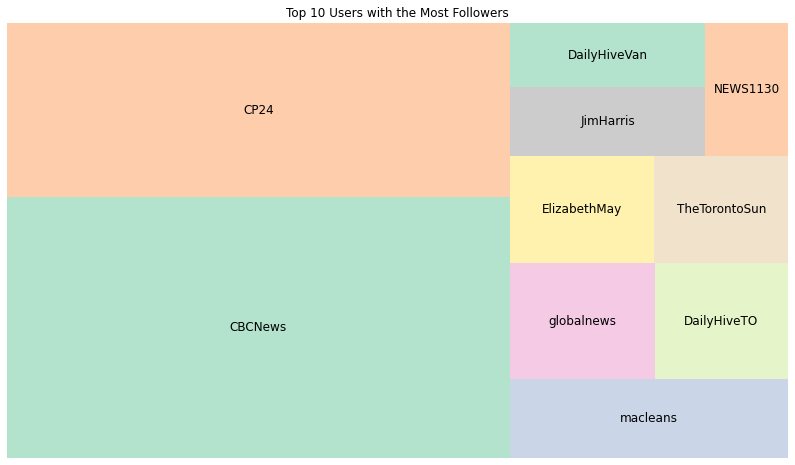

In [ ]:
# Normalize 'user' field
users = json_normalize(tweets_df['user'])
users = pd.DataFrame(users)

# Drop duplicates based on screen_name
users.drop_duplicates(subset=['screen_name'], keep='last', inplace=True)

# Determine the top 10 users by followers count
users_follower = users.sort_values(by='followers_count', ascending=False)

# Plot a treemap to visualize the top 10 users by followers count
plt.figure(figsize=(14, 8))
users_follower_10 = users_follower.head(10)
squarify.plot(sizes=users_follower_10['followers_count'], label=users_follower_10['screen_name'], text_kwargs={'fontsize': 12},
              color=sns.color_palette('Pastel2', n_colors=len(users_follower_10)))
plt.title('Top 10 Users with the Most Followers')
plt.axis('off')
plt.show()

In [ ]:
# Printing out the user description field to get a better understanding of who the users with the highest followers are
for description in users_follower_10['description']:
    print(description)
    print("--------------------")

Canadian breaking news and analysis from CBCNews.ca, TV and radio.
--------------------
Official account of CP24 - Toronto and the GTA's #1 source for breaking news. Our Twitter account is LIVE 24 hours a day.
--------------------
Canada's national current affairs and news magazine since 1905. Follow our journalists: https://t.co/h2mHnvt242
--------------------
Breaking Canadian news with a fresh perspective on local & international headlines 🚨IG: https://t.co/zVYsc0JhRh 🚨TikTok: https://t.co/OQGJLYpUJg
--------------------
Your City. Now. Your homebase for everything Toronto. Send stories/leads to toronto@dailyhive.com
--------------------
Leader of the @CanadianGreens, Candidate for Saanich-Gulf Islands, activist, author & mother. Tweets are Elizabeth's. En français - @MayElizabeth
--------------------
Toronto's best local news, sports, entertainment, comment, pictures and video.
--------------------
7 Million Strong Fighting For The Future #ClimateStrikeCanada #FridaysForFuture #Cli

In [ ]:
# Filter the data to select only migration related tweets.
migration_keywords = ['migra*', 'immigr*', 'emigra*', 'citizens*','refugee*','asylum*','border*','foreigner*','visa*']

# Filter tweets containing migration keywords
migration_related_tweets = tweets_df[tweets_df['full_text'].str.contains('|'.join(migration_keywords), case=False)]

In [ ]:
# Add column for 'userName' to the tweets_df dataframe
user_name = []
for user in migration_related_tweets['user']:
    uname = user['screen_name']
    user_name.append(uname)
migration_related_tweets['userName'] = user_name

# Remove any duplicates based on values in columns 'full_text' and 'created_at'
migration_related_tweets.drop_duplicates(subset=['full_text','created_at'], keep='last', inplace=True)

# Rename some irrelevant columns
migration_related_tweets.rename(columns={'id_str':'tweetId', 'quoted_status_id_str':'quoted_status_id'}, inplace=True)

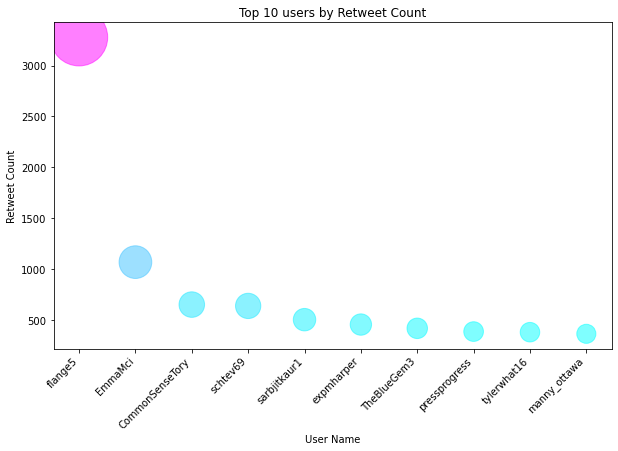

In [ ]:
# Determine the top 10 users by retweet count
users_retweet = migration_related_tweets.sort_values(by='retweet_count', ascending=False)
users_retweet.drop_duplicates(subset=['tweetId'], keep='first', inplace=True)
# Plot a bubble chart to visualize the top 10 users by retweet count
top_users = users_retweet.head(10)
colors = top_users['retweet_count']
plt.figure(figsize=(10, 6))
plt.scatter(top_users['userName'], top_users['retweet_count'],
            s=top_users['retweet_count'], cmap = 'cool', c = colors, alpha=0.5)
plt.xlabel('User Name')
plt.ylabel('Retweet Count')
plt.title('Top 10 users by Retweet Count')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# Displaying the user description field to get a better understanding about who the users with the highest retweets
matching_users = users[users['screen_name'].isin(top_users['userName'])]
for _, row in matching_users.iterrows():
    print(f"{row['screen_name']}")
    print(f"{row['description']}")
    print("--------------------")

pressprogress
We’re Canada’s most shared source for progressive news and information
--------------------
flange5
Collector of overly expensive hobbies, Decorator of ridiculously elaborate cookies, (mostly) unapologetic fangirl.
--------------------
expmharper
THIS ACCOUNT IS SATIRE, and I'm just joking. Opinions are somebody else's.  Like most schemes, it started with vodka.
--------------------
CommonSenseTory
RCAF VET,  NB to Alberta by Choice, Oil Worker. CD P.Eng
--------------------
TheBlueGem3
A Mom/ Lover of animals/ Raised by wolves/ Coffee for life/ Left Wing /Atheist/ ABC voter/Canada my home and native land
--------------------
EmmaMci
Investigative reporter covering disinformation in #elxn43 @natobserver. Likes being outside. Past: @thestarcalgary, @torontostar. DM for Signal and PGP.
--------------------
manny_ottawa
Described as an unwavering patriot. Truth sounds like hate to those who hate the Truth. You have a duty to inform yourself-or I will not be kind. Retired Law

In [ ]:
# Determine the top 10 users with the highest number of tweets in the data
tweet_counts = migration_related_tweets['userName'].value_counts()
# Sorting the tweet counts from highest to lowest
top10tweeters = tweet_counts.sort_values(ascending=False).head(10)
top10tweeters

BillTufts          38
ExpatriateNl       34
ratnaomi           32
DeceitinDrugs      29
albertarabbit      22
VictorY_Wong       22
abuconservativi    20
BobMakenzie1       19
dgeorge7007        18
TrueNorthCentre    18
Name: userName, dtype: int64

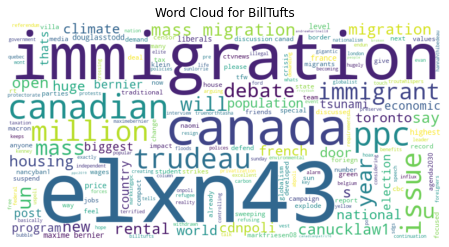

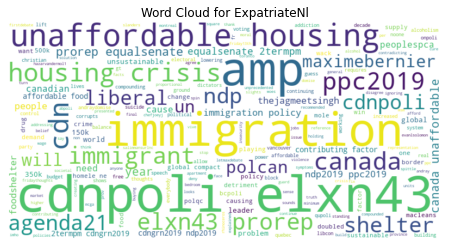

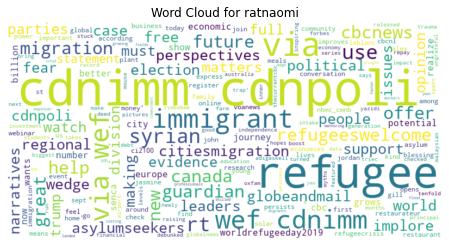

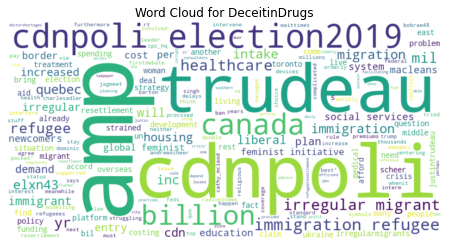

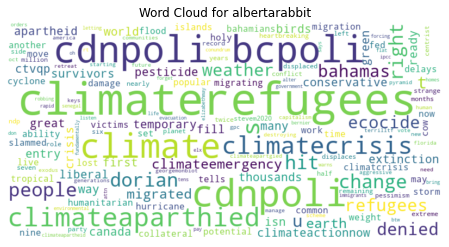

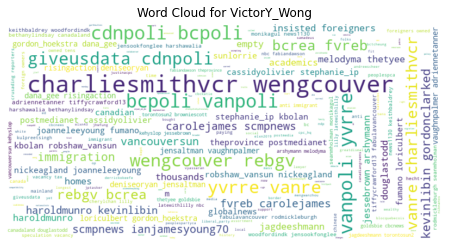

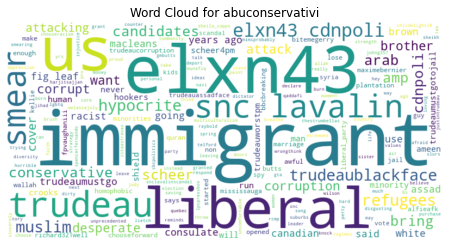

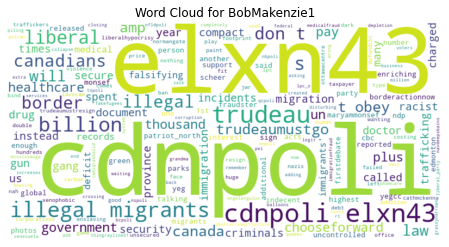

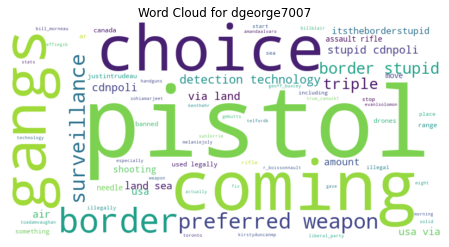

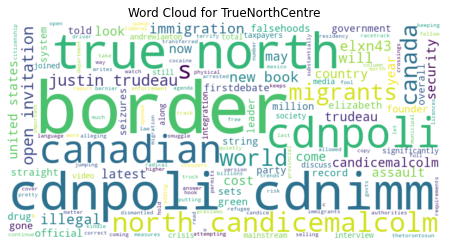

In [ ]:
# Create a word cloud to show the common words that the top 10 users with the highest number of tweets are tweeting about.
top_10_users = top10tweeters.index.tolist()
# Filter tweets for the top 10 users
top_10_tweets = migration_related_tweets[migration_related_tweets['userName'].isin(top_10_users)]
for user in top_10_users:
    user_tweets = top_10_tweets[top_10_tweets['userName'] == user]
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(user_tweets['full_text']))
    # Display the WordCloud using Matplotlib
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {user}')
    plt.axis('off')
    plt.show()

In [ ]:
# Display the user description field to try to get a better understanding about the users with the highest number of tweets
toptw_users = users[users['screen_name'].isin(top_10_users)]
for _, row in toptw_users.iterrows():
    print(f"{row['screen_name']}")
    print(f"{row['description']}")
    print("--------------------")

TrueNorthCentre
We focus on conducting research on immigration & integration issues and providing timely investigative reports on issues that affect Canada’s national security.
--------------------
dgeorge7007
Market Appraiser covering: EDMT, surrounding counties & west to Jasper; nw to Fox Creek and other counties. DAR  & Certified Appraisal Reviewer.  Res & Biz.
--------------------
abuconservativi
Abu Sheer supporter
There is no God but Allah
Muhammad is the Prophet of Allah
Sheer is Prime Minister of Allah
Photos are of people I admire, not me. #elxn43
--------------------
BobMakenzie1
Canada. Freedom isn't free. Neither is Healthcare. 🇨🇦🇺🇸 #BackTheBlue
--------------------
albertarabbit
Our environment sustains us: protect it. Neoliberalism/consumerism: mankind's downfall. Common sense: use it. Tweets are my opinion. RTs are not endorsements.
--------------------
BillTufts
Fair Pensions For All ... https://t.co/cc2IK6B7ks
A little more about me   https://t.co/kqm09sfd8Z
----------

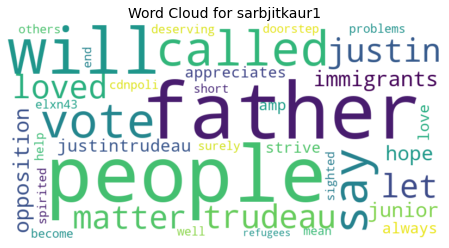

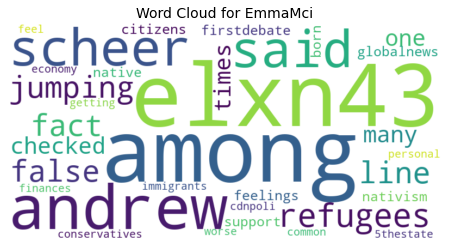

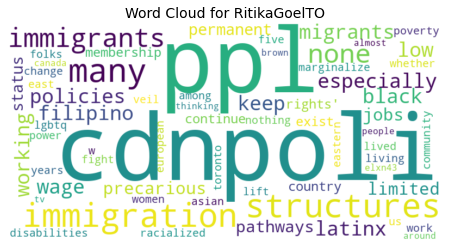

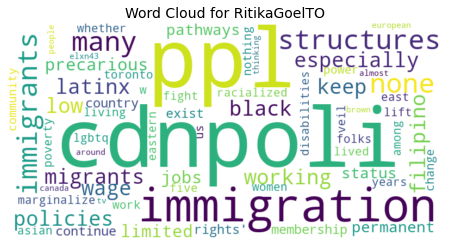

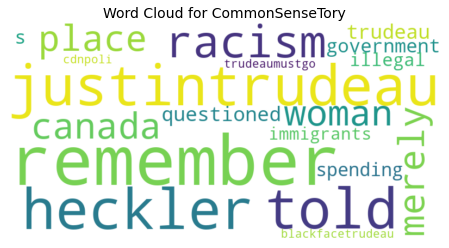

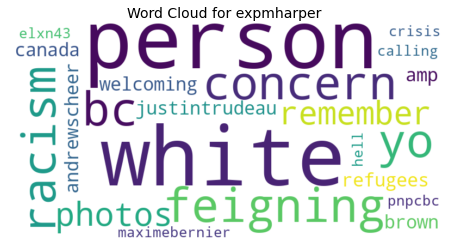

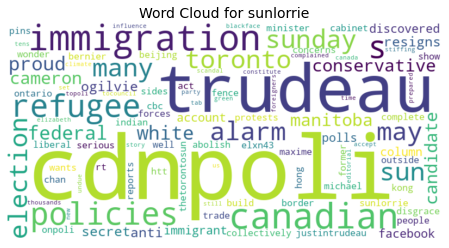

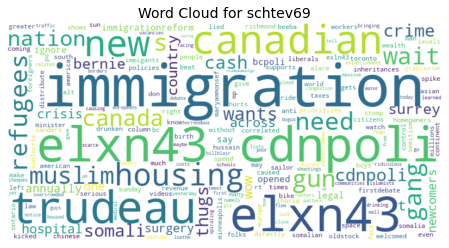

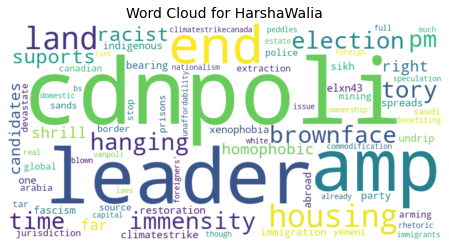

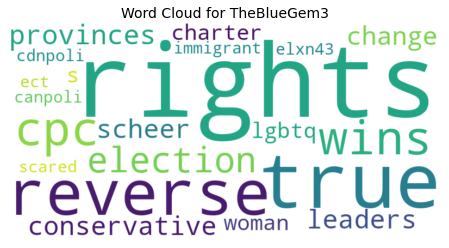

In [ ]:
# Determine top 10 users by favorite count
users_fav = migration_related_tweets.sort_values(by='favorite_count', ascending=False)
users_fav.drop_duplicates(subset=['tweetId'], keep='first', inplace=True)

# Create a word cloud to show the common words that the top 10 users with the highest favorite count are tweeting about.
top10_fav_users = users_fav.head(10)['userName'].tolist()

# Filter tweets for the top 10 users
top_10_fav = migration_related_tweets[migration_related_tweets['userName'].isin(top10_fav_users)]
for user in top10_fav_users:
    fav_user_tweets = top_10_fav[top_10_fav['userName'] == user]
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(fav_user_tweets['full_text']))
    # visualize using Word Cloud
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {user}', fontsize = 14)
    plt.axis('off')
    plt.show()

In [ ]:
# Printing out the user description field to get a better understanding about who the users with the highest favorite count are
topfv_users = users[users['screen_name'].isin(top10_fav_users)]
for _, row in topfv_users.iterrows():
    print(f"{row['screen_name']}")
    print(f"{row['description']}")
    print("--------------------")

expmharper
THIS ACCOUNT IS SATIRE, and I'm just joking. Opinions are somebody else's.  Like most schemes, it started with vodka.
--------------------
CommonSenseTory
RCAF VET,  NB to Alberta by Choice, Oil Worker. CD P.Eng
--------------------
TheBlueGem3
A Mom/ Lover of animals/ Raised by wolves/ Coffee for life/ Left Wing /Atheist/ ABC voter/Canada my home and native land
--------------------
EmmaMci
Investigative reporter covering disinformation in #elxn43 @natobserver. Likes being outside. Past: @thestarcalgary, @torontostar. DM for Signal and PGP.
--------------------
RitikaGoelTO
Family doctor. Activist. Mom. Both immigrant and settler. Tweets on health, politics & social justice. Part of @OHIPforAll @CdnDrs4Medicare @DecentWorkHlth.
--------------------
HarshaWalia
author Undoing Border Imperialism. Sikh. Inquilab. Antifa. tweet obvious & obscure: race feminism empire capitalism migration imperialism dtes indigenous tierra
--------------------
sunlorrie
Editor Emeritus, Columnis

In [ ]:
# Extract the 'full_text' column from the dataframe and assign it to variable tweet_text
tweet_text = migration_related_tweets[['full_text']]

# Pre-processing tweet using the preprocess function
processed_tweet = tweet_text['full_text'].map(preprocess)

# Create a gensim dictionary
dictionary = gensim.corpora.Dictionary(processed_tweet)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break
# Filter any extremes. Kkeep only words that appear in at least 30 documents and at most 80% of the tweet, and keep maximum 3000 words
dictionary.filter_extremes(no_below=30, no_above=0.8,keep_n = 3000)

# Create bag of words
tweet_doc = [dictionary.doc2bow(doc) for doc in processed_tweet]

0 cdnpoli
1 ctvnew
2 immigr
3 wait
4 wonder
5 border
6 canadian
7 cheap
8 disrupt
9 elect
10 globalist


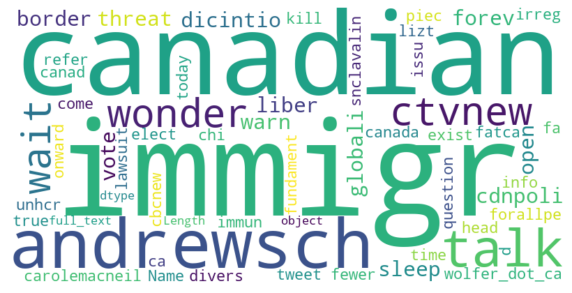

In [ ]:
# Create a WordCloud
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(str(processed_tweet))

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
timestamps = {tweet_id: tweet.get("created_at") for tweet_id, tweet in tweets_df.iterrows()}

# Create a DataFrame to store aggregated sentiment scores
agg_sentiments_df = pd.DataFrame(columns=["date", "overall_sentiment"])

# Iterate through tweets and calculate sentiment scores
for _, tweet in tweets_df.iterrows():
    tweet_text = tweet.get("full_text", "")
    blob = TextBlob(tweet_text)
    sentiment_score = blob.sentiment.polarity

    # Extract date from timestamp
    date = timestamps[tweet.name].date()

    # Append sentiment scores to the DataFrame
    agg_sentiments_df = agg_sentiments_df.append({"date": date, "overall_sentiment": sentiment_score}, ignore_index=True)

# Group by date and calculate the average sentiment score
agg_sentiments_df = agg_sentiments_df.groupby("date").mean().reset_index()

# Plot overall sentiment change over time
fig = px.line(agg_sentiments_df, x="date", y="overall_sentiment", markers=True,
              hover_data={"date": "|%B %d, %Y", "overall_sentiment": ":.3f"})

fig.update_layout(
    title="Overall Sentiment Over Time",
    xaxis_title="Date",
    yaxis_title="Overall Sentiment Score"
)
fig.show()


In [ ]:
# Create a dictionary to map tweet IDs to their corresponding timestamps
timestamps1 = {tweet_id: tweet.get("created_at") for tweet_id, tweet in top_10_fav.iterrows()}

# Create a dataframe to store sentiment scores
sentiments_df = pd.DataFrame(columns=["userName", "timestamp", "sentiment"])

# Iterate through tweets and calculate sentiment scores
for _, tweet in top_10_fav.iterrows():
    user_info = tweet.get("user")
    tweet_text = tweet.get("full_text", "")
    if isinstance(user_info, dict):
        user = user_info.get("screen_name")
        blob = TextBlob(tweet_text)
        sentiment_score = blob.sentiment.polarity
        # Append sentiment scores to the DataFrame
        sentiments_df = sentiments_df.append({"userName": user, "timestamp": timestamps1[tweet.name],
                                              "sentiment": sentiment_score}, ignore_index=True)

# Plot interactive line chart with Plotly showing the sentiment change from one day to the other for each user
fig2 = px.line(sentiments_df, x="timestamp", y="sentiment", color="userName", markers=True, line_group="userName",
              hover_name="userName", hover_data={"userName": False, "timestamp": "|%B %d, %Y %I:%M:%S %p", "sentiment": ":.3f"})
fig2.update_layout(
    title="Sentiments Over Time for Top 10 Users with the highest favorite count",
    xaxis_title="Date",
    yaxis_title="Sentiment Score",
    legend_title="User")
fig2.show()

In [ ]:
# Create a dictionary to map tweet IDs to their corresponding timestamps
timestamps2 = {tweet_id: tweet.get("created_at") for tweet_id, tweet in top_10_tweets.iterrows()}

# Create a dataframe to store sentiment scores
sentiments_df2 = pd.DataFrame(columns=["userName", "date", "sentiment"])

# Iterate through tweets and calculate sentiment scores
for _, tweet in top_10_tweets.iterrows():
    user_info = tweet.get("user")
    tweet_text = tweet.get("full_text", "")
    if isinstance(user_info, dict):
        user = user_info.get("screen_name")
        blob = TextBlob(tweet_text)
        sentiment_score = blob.sentiment.polarity
        # Append sentiment scores to the DataFrame
        sentiments_df2 = sentiments_df2.append({"userName": user, "date": timestamps2[tweet.name],"sentiment": sentiment_score}, ignore_index=True)

# Plot interactive line chart with Plotly showing the sentiment change from one day to the other for each user
fig3 = px.line(sentiments_df2, x="date", y="sentiment", color="userName", markers=True, line_group="userName",
              hover_name="userName", hover_data={"userName": False, "date": "|%B %d, %Y %I:%M:%S %p", "sentiment": ":.3f"},
              facet_col="userName", facet_col_wrap=4)

fig3.update_layout(
    title="Sentiments over time for Top 10 Users with the highest tweets",
    xaxis_title="Date",
    yaxis_title="Sentiment Score",
    legend_title="User",
    height=1000,
    width=1000)
fig3.show()

## Noticing the very low overall sentiment on Sep 13, 2019, let's explore to see what some of the common words on each day was and then see how that defers from other days.

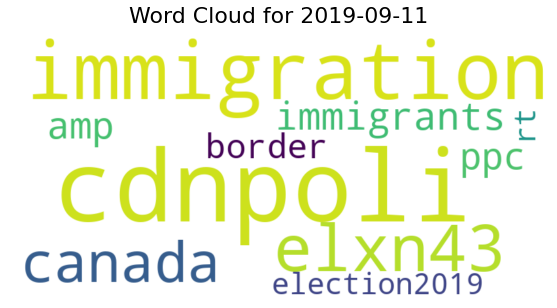

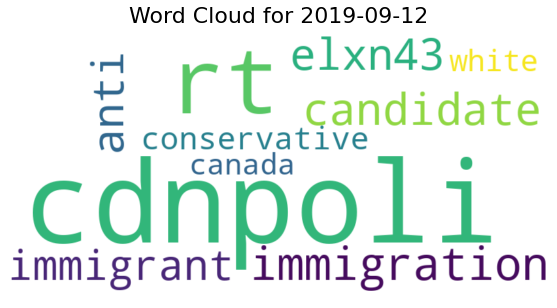

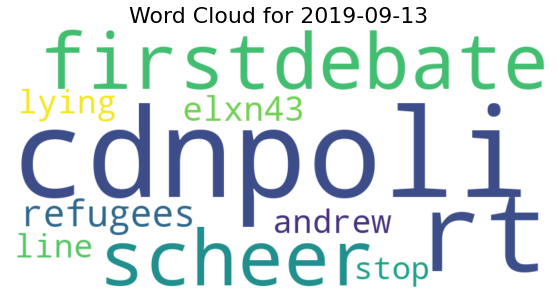

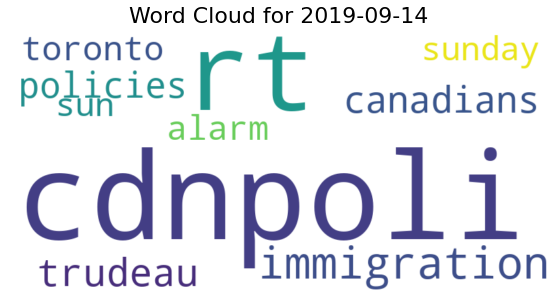

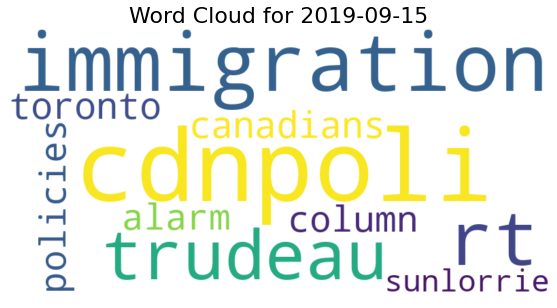

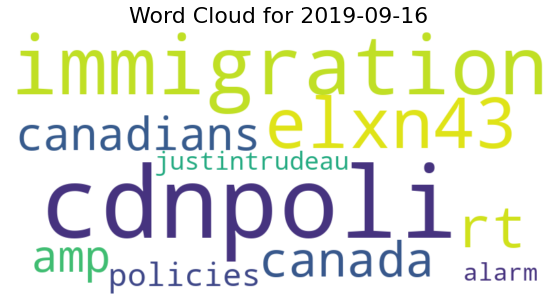

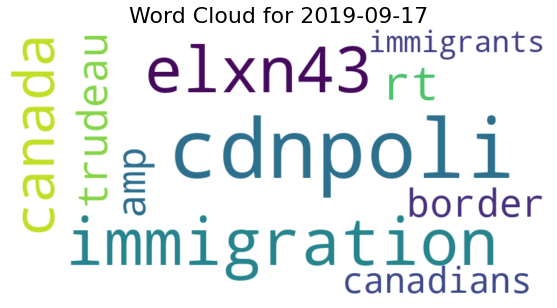

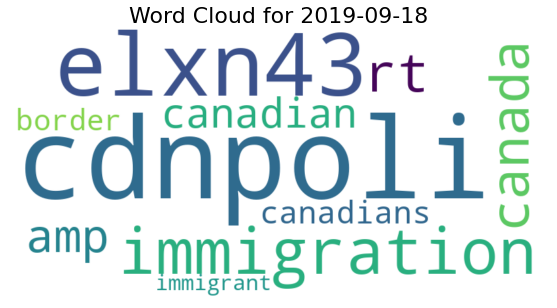

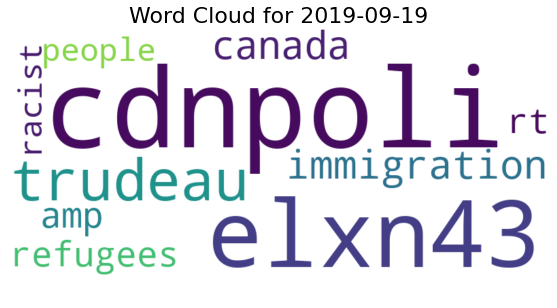

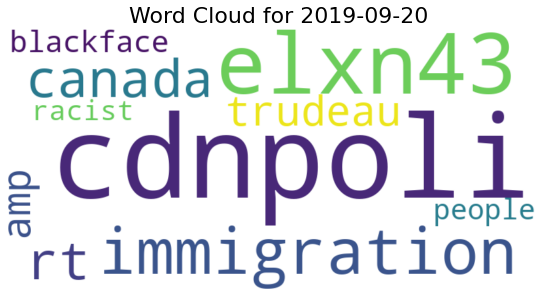

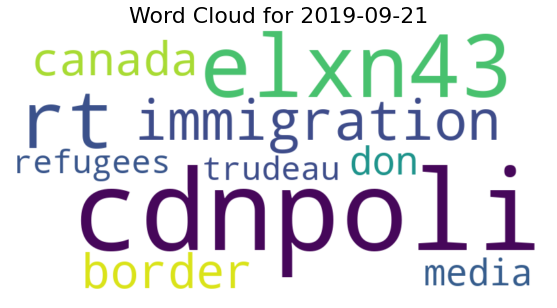

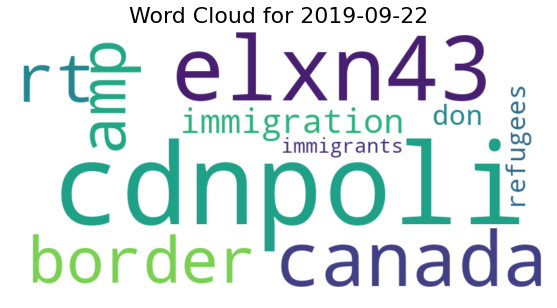

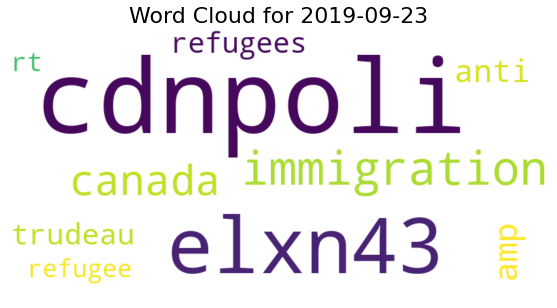

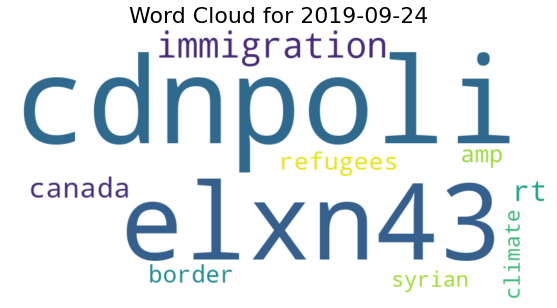

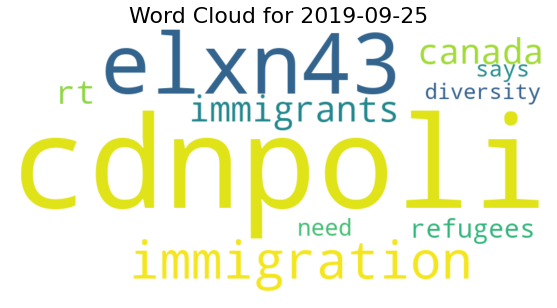

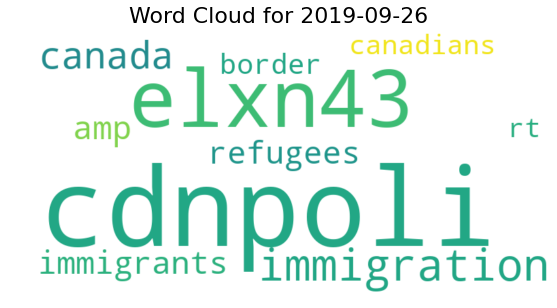

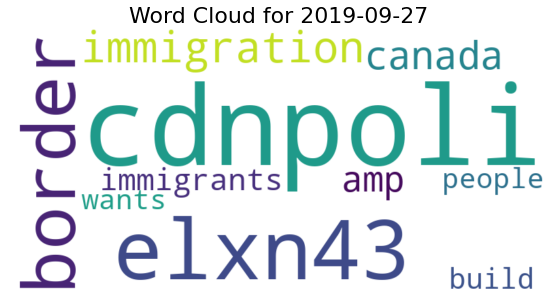

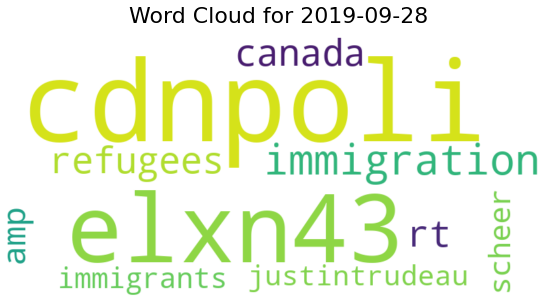

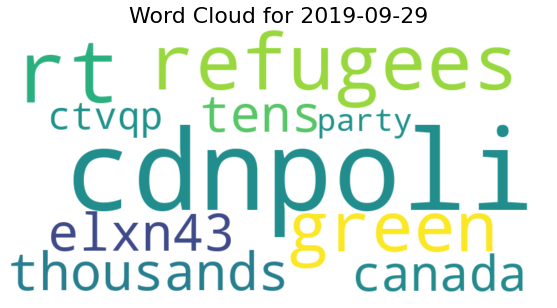

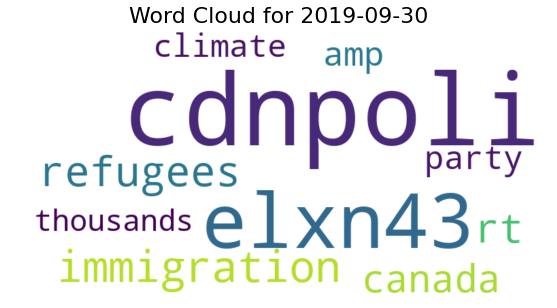

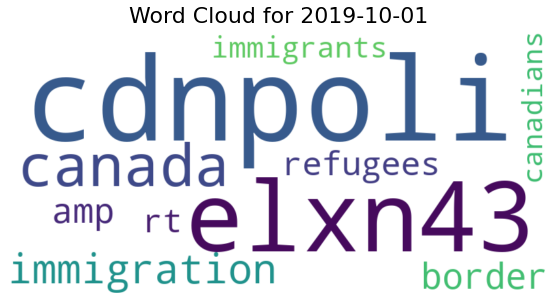

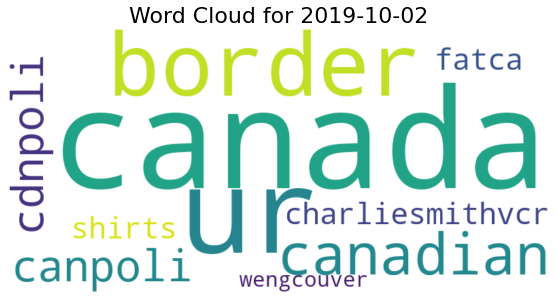

In [ ]:
# Extract date from timestamp
tweets_df['date'] = tweets_df['created_at'].dt.date

# Initialize CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=10)

# Iterate through unique dates
for date in tweets_df['date'].unique():
    # Filter tweets for the current date
    tweets_for_date = tweets_df[tweets_df['date'] == date]

    # Fit and transform the text data for the current date
    word_counts = vectorizer.fit_transform(tweets_for_date['full_text'])

    # Get feature names (words) and their counts
    features = vectorizer.get_feature_names_out()
    counts = word_counts.sum(axis=0).A1

    # Create a dictionary of words and their counts
    word_count_dict = dict(zip(features, counts))

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_count_dict)

    # Display the WordCloud using Matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {date}', fontsize = 22)
    plt.axis('off')
    plt.show()


## Words like 'scheer', 'refugees', 'lying', 'firstdebate' were commonly used on Sep 13 2019. Sep 13 was possibly the day that the first debate was held.

In [ ]:
# Filter tweets to see some of the tweets on Sep 13th.
tweets_for_date = migration_related_tweets[migration_related_tweets['created_at'].dt.date == pd.to_datetime('2019-09-13')]

# Print the full text of each tweet
for index, tweet in tweets_for_date.iterrows():
    print(tweet['full_text'])
    print('.' * 50)  # Separating tweets with multiple dots for better readability

rt @wearenorth99: scheer is fear-mongering about refugees just like donald trump #cdnpoli 
..................................................
in this #firstdebate i hope we talk about immigration and the pipeline. although i can already imagine where these folks stand #scheerterror #elxn43 #elxn2019 #cdnpoli
..................................................
rt @whataboutmadmax: sean paterson, sudbury's candidate for the people's party, just wants 'responsible immigration' #cdnpoli #ppc2019 #ber…
..................................................
@elizabethmay thinks #indigenous communities get clean water when a corporation commits a crime. @thejagmeetsingh called  her wacky idea ludicrous/she got mad. @canadiangreens' plan is completely thoughtless &amp; borderline  #racist. #elxn43 #debatenight @cbcnews @ctvnews @aptnnews
..................................................
rt @migrantrightsca: #elxn43 #debatenight

we are watching for divisive politics and how anti-immigrant racism i

## Reading some of this tweets confirms the speculation that Sep 13 was the first debate night. I also notice a lot of negative sentiments in the tweets towards Justin Trudeau. This also explains the spike in the number of tweets per day on Sep 13.

In [ ]:
liberal_keywords = ['liberal*', 'justintrudeau*', 'trudeau*']
# Filter tweets containing liberal party related keywords
liberal_related_tweets = migration_related_tweets[migration_related_tweets['full_text'].str.contains('|'.join(liberal_keywords), case=False)]
liberal_related_tweets

created_at              tweetId  \
2    2019-09-11 14:46:19  1171797123605651458   
5    2019-09-11 17:24:22  1171836896986615808   
6    2019-09-11 13:45:48  1171781890958856192   
8    2019-09-11 18:33:45  1171854357337391106   
17   2019-09-11 14:30:15  1171793077121499138   
...                  ...                  ...   
4917 2019-10-01 21:10:32  1179141568726364160   
4939 2019-10-01 19:29:21  1179116105438306304   
4941 2019-10-01 20:02:21  1179124410340593666   
4955 2019-10-01 19:50:59  1179121551389671424   
4960 2019-10-01 19:48:56  1179121037377769472   

                                              full_text display_text_range  \
2     @dicintio you will be sleeping forever! #vote ...          [10, 283]   
5     in 1980, sen. keith davey, campaign strategist...           [0, 253]   
6     @sideshow_bo either he's stupid &amp; naive or...          [13, 294]   
8     rt @truenorthcentre: trudeau’s open invitation...           [0, 140]   
17    yes #liberals winning this #elexn43 to preserv...           [0, 280]   
...                                                 ...                ...   
4917  liberal 2019 immigration platform #cdnpoli\n- ...           [0, 279]   
4939  this is frightening! @idu_secretariat chair - ...           [0, 281]   
4941  @carolemacneil how many immigrants will be all...          [15, 267]   
4955  @carolemacneil why do tax payers have to foot ...          [15, 116]   
4960  @carolemacneil why does the @liberal_party tre...          [15, 103]   

                                               entities  \
2     {'hashtags': [{'text': 'VOTE', 'indices': [40,...   
5     {'hashtags': [{'text': 'cdnpoli', 'indices': [...   
6     {'hashtags': [{'text': 'Trudeau', 'indices': [...   
8     {'hashtags': [{'text': 'cdnpoli', 'indices': [...   
17    {'hashtags': [{'text': 'Liberals', 'indices': ...   
...                                                 ...   
4917  {'hashtags': [{'text': 'cdnpoli', 'indices': [...   
4939  {'hashtags': [{'text': 'elxn43', 'indices': [2...   
4941  {'hashtags': [{'text': 'Canada', 'indices': [5...   
4955  {'hashtags': [{'text': 'cdnpoli', 'indices': [...   
4960  {'hashtags': [{'text': 'Canadians', 'indices':...   

                                                 source  \
2     <a href="http://twitter.com/download/iphone" r...   
5     <a href="https://mobile.twitter.com" rel="nofo...   
6     <a href="https://mobile.twitter.com" rel="nofo...   
8     <a href="https://mobile.twitter.com" rel="nofo...   
17    <a href="http://twitter.com/download/iphone" r...   
...                                                 ...   
4917  <a href="https://mobile.twitter.com" rel="nofo...   
4939  <a href="http://twitter.com/download/android" ...   
4941  <a href="https://mobile.twitter.com" rel="nofo...   
4955  <a href="https://mobile.twitter.com" rel="nofo...   
4960  <a href="https://mobile.twitter.com" rel="nofo...   

      in_reply_to_status_id in_reply_to_status_id_str  in_reply_to_user_id  \
2              1.171774e+18       1171774272139751424         2.149084e+07   
5                       NaN                      None                  NaN   
6              1.171667e+18       1171666642914426885         1.037728e+18   
8                       NaN                      None                  NaN   
17                      NaN                      None                  NaN   
...                     ...                       ...                  ...   
4917                    NaN                      None                  NaN   
4939                    NaN                      None                  NaN   
4941           1.179102e+18       1179102068738531329         2.474111e+08   
4955           1.179102e+18       1179102068738531329         2.474111e+08   
4960           1.179102e+18       1179102068738531329         2.474111e+08   

     in_reply_to_user_id_str  ... favorited retweeted lang  \
2                   21490843  ...     False     False   en   
5        

In [ ]:
# Determine the count of liberal-related tweets for each userName
lib_tweet_counts = liberal_related_tweets['userName'].value_counts()
# Sorting the tweet counts from highest to lowest and then selecting only the top 10
toplibtweeters = lib_tweet_counts.sort_values(ascending=False).head(10)
toplibtweeters

PNozhka            17
BobMakenzie1       15
abuconservativi    15
DeceitinDrugs      15
myjss86            13
sparkyb1           11
BillTufts          10
ChicDelights8      10
SpeakeasyJames     10
addagio999          9
Name: userName, dtype: int64

In [ ]:
# Assigning the list of userName to toplibtweeters
toplibtweeters = toplibtweeters.index.tolist()

In [ ]:
# Filter tweets for the top 10 users with the most liberal-related tweets
top10_lib_tweets = migration_related_tweets[migration_related_tweets['userName'].isin(toplibtweeters)]

# Create a dictionary to map tweet IDs to their corresponding timestamps
lib_timestamps = {tweet_id: tweet.get("created_at") for tweet_id, tweet in top10_lib_tweets.iterrows()}

# Create a dataframe to store sentiment scores
lib_sentiments = pd.DataFrame(columns=["userName", "date", "sentiment"])

# Iterate through tweets and calculate sentiment scores
for _, tweet in top10_lib_tweets.iterrows():
    user_info = tweet.get("user")
    tweet_text = tweet.get("full_text", "")
    if isinstance(user_info, dict):
        user = user_info.get("screen_name")
        blob = TextBlob(tweet_text)
        sentiment_score = blob.sentiment.polarity
        # Append sentiment scores to the DataFrame
        lib_sentiments = lib_sentiments.append({"userName": user, "date": lib_timestamps[tweet.name],"sentiment": sentiment_score}, ignore_index=True)

# Plot interactive line chart with Plotly showing the sentiment change from one day to the other for each user
lib_fig = px.line(lib_sentiments, x="date", y="sentiment", color="userName", markers=True, line_group="userName",
              hover_name="userName", hover_data={"userName": False, "date": "|%B %d, %Y %I:%M:%S %p", "sentiment": ":.3f"},
              facet_col="userName", facet_col_wrap=5)

lib_fig.update_layout(
    title="Sentiments over time for Top 10 Users with the most liberal-related tweets",
    xaxis_title="Date",
    yaxis_title="Sentiment Score",
    legend_title="User",
    height=800,
    width=1000)
lib_fig.show()

In [ ]:
conservative_keywords = ['conservative*', 'andrew*', 'scheer*','andrewscheer','trudeaumustgo']
# Filter tweets containing conservative party related keywords
conservative_related_tweets = migration_related_tweets[migration_related_tweets['full_text'].str.contains('|'.join(conservative_keywords), case=False)]
conservative_related_tweets

created_at              tweetId  \
2    2019-09-11 14:46:19  1171797123605651458   
3    2019-09-11 19:10:27  1171863594746687488   
11   2019-09-11 17:08:16  1171832846987587591   
12   2019-09-11 14:58:29  1171800185720229888   
15   2019-09-11 01:45:00  1171600496257167360   
...                  ...                  ...   
4950 2019-10-01 21:09:39  1179141347992842241   
4952 2019-10-02 01:36:56  1179208611416936448   
4957 2019-10-02 01:37:39  1179208794653564928   
4958 2019-10-01 21:16:26  1179143054357389314   
4964 2019-10-01 23:47:22  1179181040423854080   

                                              full_text display_text_range  \
2     @dicintio you will be sleeping forever! #vote ...          [10, 283]   
3     so if #snclavalin never existed at all what wo...           [0, 277]   
11    not referring to mad max's odious party but #c...           [0, 277]   
12    there could be a significant shift on immigrat...           [0, 100]   
15    r.i.p. fred herzog, photographic artisan. he w...           [0, 229]   
...                                                 ...                ...   
4950  like clockwork, more from conservatives on how...           [0, 265]   
4952  @andrewscheer the world grows smaller by the m...          [14, 301]   
4957  playing to anti immigrant fears #andrewscheer ...           [0, 168]   
4958  rt @stevenzzhou: like clockwork, more from con...           [0, 140]   
4964  "fundamentally, ⁦@andrewscheer⁩ is talking abo...           [0, 255]   

                                               entities  \
2     {'hashtags': [{'text': 'VOTE', 'indices': [40,...   
3     {'hashtags': [{'text': 'SNCLavalin', 'indices'...   
11    {'hashtags': [{'text': 'cdnpoli', 'indices': [...   
12    {'hashtags': [{'text': 'Election2019', 'indice...   
15    {'hashtags': [{'text': 'PPC', 'indices': [155,...   
...                                                 ...   
4950  {'hashtags': [{'text': 'cdnpoli', 'indices': [...   
4952  {'hashtags': [{'text': 'ScheerIgnorance', 'ind...   
4957  {'hashtags': [{'text': 'andrewscheer', 'indice...   
4958  {'hashtags': [{'text': 'cdnpoli', 'indices': [...   
4964  {'hashtags': [{'text': 'canpoli', 'indices': [...   

                                                 source  \
2     <a href="http://twitter.com/download/iphone" r...   
3     <a href="http://twitter.com" rel="nofollow">Tw...   
11    <a href="https://mobile.twitter.com" rel="nofo...   
12    <a href="http://twitter.com/download/iphone" r...   
15    <a href="https://mobile.twitter.com" rel="nofo...   
...                                                 ...   
4950  <a href="https://mobile.twitter.com" rel="nofo...   
4952  <a href="https://mobile.twitter.com" rel="nofo...   
4957  <a href="http://twitter.com/download/android" ...   
4958  <a href="http://twitter.com/download/iphone" r...   
4964  <a href="http://twitter.com/download/iphone" r...   

      in_reply_to_status_id in_reply_to_status_id_str  in_reply_to_user_id  \
2              1.171774e+18       1171774272139751424           21490843.0   
3                       NaN                      None                  NaN   
11                      NaN                      None                  NaN   
12                      NaN                      None                  NaN   
15                      NaN                      None                  NaN   
...                     ...                       ...                  ...   
4950                    NaN                      None                  NaN   
4952           1.179174e+18       1179174251955441669          256360738.0   
4957                    NaN                      None                  NaN   
4958                    NaN                      None                  NaN   
4964                    NaN                      None                  NaN   

     in_reply_to_user_id_str  ... favorited retweeted lang  \
2                   21490843  ...     False     False   en   
3        

In [ ]:
# Determine the count of conservative party-related tweets for each userName
con_tweet_counts = conservative_related_tweets['userName'].value_counts()
# Sorting the tweet counts from highest to lowest and then selecting only the top 10
topcontweeters = con_tweet_counts.sort_values(ascending=False).head(10)
topcontweeters

CSUnited2014       13
addagio999         11
abuconservativi    10
DrGillLeighton      8
WestBench           5
wearenorth99        5
AmRedPilled         5
joanvw09            5
Evenings_Star       5
1loriking           5
Name: userName, dtype: int64

In [ ]:
# Assigning the list of userName to topcontweeters
topcontweeters = topcontweeters.index.tolist()

In [ ]:
# Filter tweets for the top 10 users with the most conservative-related tweets
top10_con_tweets = migration_related_tweets[migration_related_tweets['userName'].isin(topcontweeters)]

# Create a dictionary to map tweet IDs to their corresponding timestamps
con_timestamps = {tweet_id: tweet.get("created_at") for tweet_id, tweet in top10_con_tweets.iterrows()}

# Create a dataframe to store sentiment scores
con_sentiments = pd.DataFrame(columns=["userName", "date", "sentiment"])

# Iterate through tweets and calculate sentiment scores
for _, tweet in top10_con_tweets.iterrows():
    user_info = tweet.get("user")
    tweet_text = tweet.get("full_text", "")
    if isinstance(user_info, dict):
        user = user_info.get("screen_name")
        blob = TextBlob(tweet_text)
        sentiment_score = blob.sentiment.polarity
        # Append sentiment scores to the DataFrame
        con_sentiments = con_sentiments.append({"userName": user, "date": con_timestamps[tweet.name],"sentiment": sentiment_score}, ignore_index=True)

# Plot interactive line chart with Plotly showing the sentiment change for each user
con_fig = px.line(con_sentiments, x="date", y="sentiment", color="userName", markers=True, line_group="userName",
              hover_name="userName", hover_data={"userName": False, "date": "|%B %d, %Y %I:%M:%S %p", "sentiment": ":.3f"},
              facet_col="userName", facet_col_wrap=5)

con_fig.update_layout(
    title="Sentiments over time for Top 10 Users with the most conservative-related tweets",
    xaxis_title="Date",
    yaxis_title="Sentiment Score",
    legend_title="User",
    height=800,
    width=1000)
con_fig.show()